### Prediction model for DAENERGY

In the following notebook are considered two different approach to predict the price of DAENERGY

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from src.process_data import pivot_data, create_index, clean_data

/Users/David/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Loading and cleaning data

- Pivot table
- It's considered data from 2017-07-05 to 2017-10-30
- There are some missing values. Those values where computed using replicating the value of the previous observation (To obtain an index with hourly frequency and obtain forecasts using stats models.
- It's created the index with TRADEDATE and HOUROFWEEK. Finally we obtain the exact date and time of trade.


In [2]:
df = pivot_data('data/Data.txt')
df = clean_data(df)
df = create_index(df)

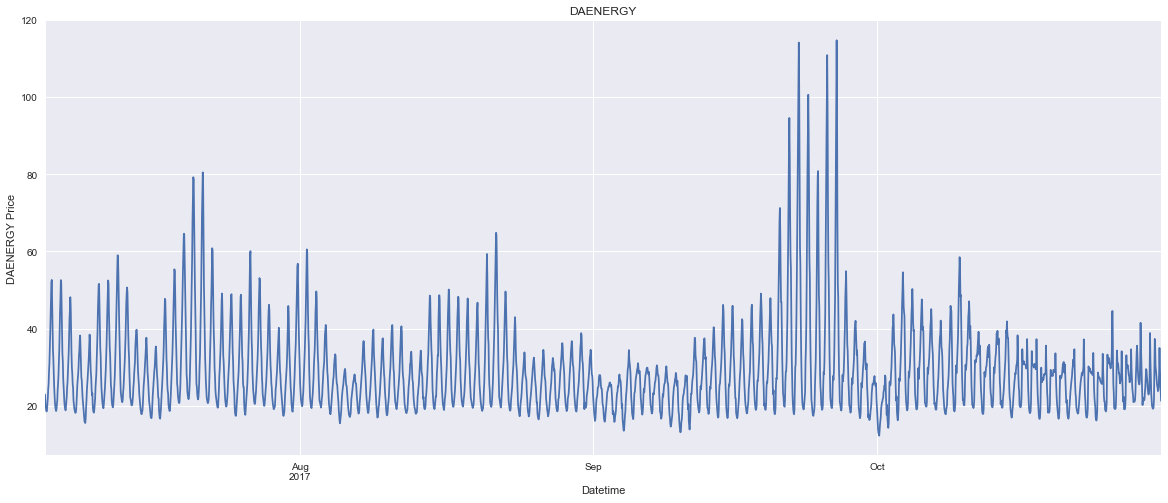

In [3]:
plt.figure(figsize=(20,8))
df.DAENERGY.plot()
plt.title('DAENERGY')
plt.xlabel('Datetime')
plt.ylabel('DAENERGY Price');

In [4]:
df.head()

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-05 01:00:00,2017-07-05,73,67,63,66,77,83,70,80,69,...,81,67,68,70,78515,22.89,22.06,4576.170,14310,01:00:00
2017-07-05 02:00:00,2017-07-05,74,63,62,67,81,84,69,84,63,...,80,68,61,66,68721,20.17,19.97,2952.209,13300,02:00:00
2017-07-05 03:00:00,2017-07-05,75,62,62,66,80,82,69,82,62,...,79,68,61,65,65820,19.42,19.41,2791.408,13300,03:00:00
2017-07-05 04:00:00,2017-07-05,76,61,62,66,78,80,69,80,61,...,78,67,60,64,64262,18.74,19.09,2525.984,13300,04:00:00
2017-07-05 05:00:00,2017-07-05,77,59,61,66,75,79,68,80,60,...,77,67,59,64,64020,18.49,18.64,2520.608,13300,05:00:00


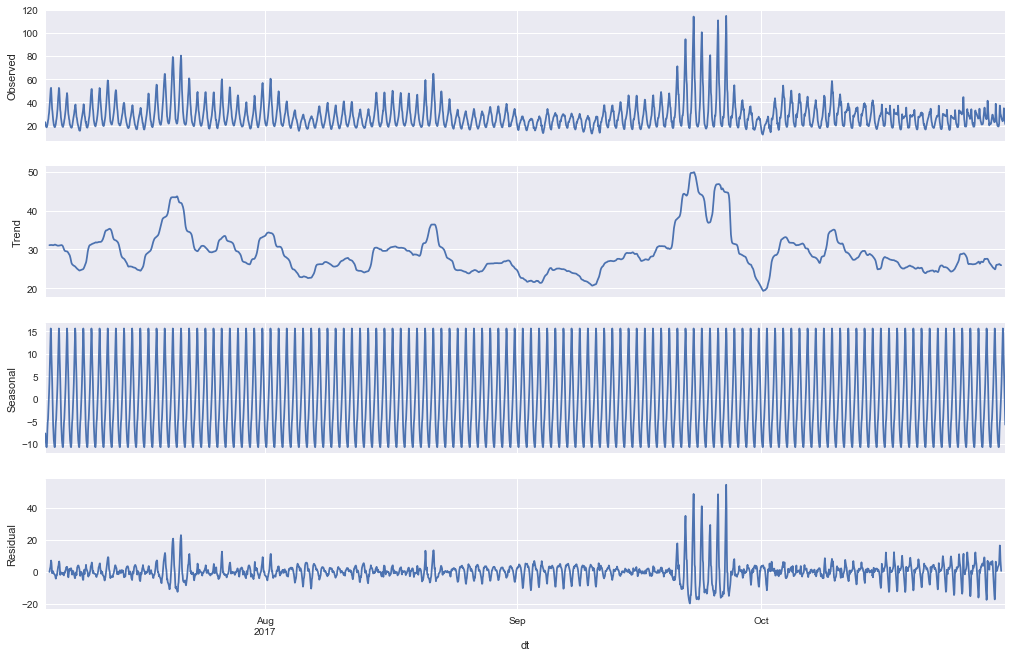

In [5]:
decomposition = seasonal_decompose(df.DAENERGY, freq = 24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 10)

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=24)
    #rolstd = pd.rolling_std(timeseries, window=24)
    rolmean = pd.Series.rolling(timeseries, window=24, center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=24, center=False).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

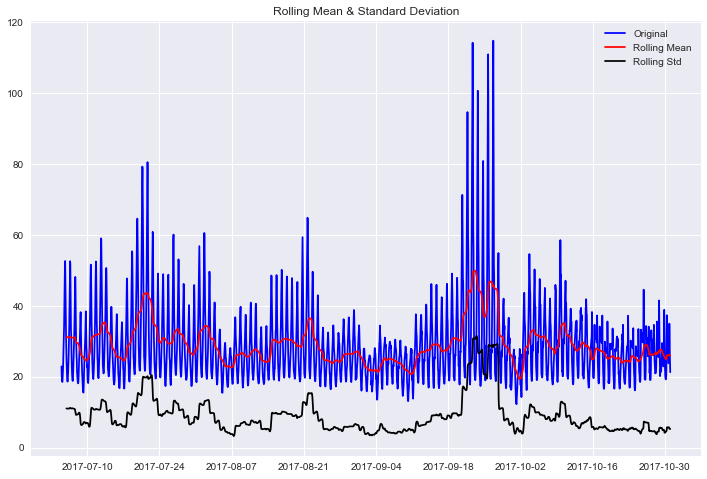

Results of Dickey-Fuller Test:
Test Statistic                   -3.517626
p-value                           0.007546
#Lags Used                       26.000000
Number of Observations Used    2805.000000
Critical Value (1%)              -3.432683
Critical Value (5%)              -2.862571
Critical Value (10%)             -2.567319
dtype: float64


In [7]:
test_stationarity(df.DAENERGY)

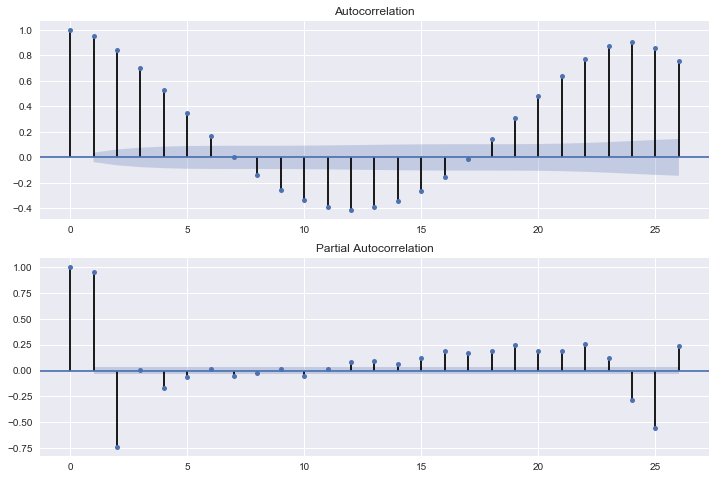

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.DAENERGY.iloc[25:], lags=26, ax=ax1, alpha = 0.05)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.DAENERGY.iloc[25:], lags=26, ax=ax2,alpha = 0.05)

### SARIMAX MODEL

In [9]:
def create_model(dd, date_predict, exogens):
    mod = sm.tsa.statespace.SARIMAX(dd.DAENERGY,exogen = dd[exogens], trend='n', order=(0,1,0), seasonal_order=(1,1,1,24))
    results = mod.fit()
    print (results.summary())
    pred = results.forecast(24)
    real = df[date_predict].DAENERGY
    RMSE=get_rmse(pred,real)
    plt.plot(df[date_predict].index, real,'g',pred.index,pred,'r' )
    plt.title('RMSE = {:.2f}'.format(RMSE))
    plt.xlabel('time')
    plt.ylabel('Price DAENERGY')
    return results, mod

def get_rmse(pred, real):
    return np.sqrt(((pred-real)**2).sum()/(pred.shape[0]))

In [10]:
temps = []
for col in df.columns.values:
    if len(col)==4:
        temps.append(col)
        
def check_bad_data(df):
    temp = df.groupby('TRADEDATE').count()['HOUROFWEEK']
    temp[temp<24]
    df[df['TRADEDATE'] == '2017-10-25']
    

#### Training the Model
Using historical data until one day before of the day to predict

                                 Statespace Model Results                                 
Dep. Variable:                           DAENERGY   No. Observations:                 1007
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 24)   Log Likelihood               -1510.882
Date:                            Tue, 14 Nov 2017   AIC                           3027.763
Time:                                    21:32:48   BIC                           3042.508
Sample:                                07-05-2017   HQIC                          3033.365
                                     - 08-15-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6273      0.023     27.832      0.000       0.583       0.672
ma.S.L24      -0.9980      0.411   

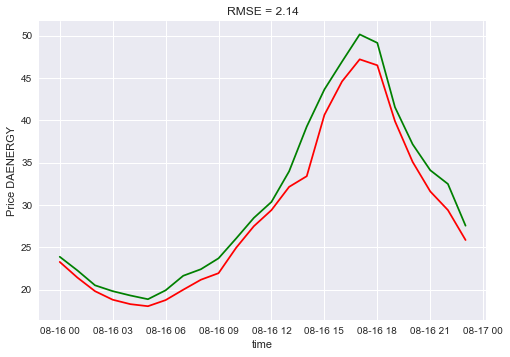

In [11]:
res, mod = create_model(df[:'2017-08-15'],'2017-08-16',temps)

In [12]:
fcast = res.get_forecast(24)
fcast_ci= fcast.conf_int(alpha=0.25)
print(fcast.predicted_mean)
print('')
print('75% of Confidence Interval')
print(fcast_ci)

2017-08-16 00:00:00    23.263588
2017-08-16 01:00:00    21.414918
2017-08-16 02:00:00    19.806389
2017-08-16 03:00:00    18.799214
2017-08-16 04:00:00    18.276334
2017-08-16 05:00:00    18.032800
2017-08-16 06:00:00    18.754888
2017-08-16 07:00:00    19.980104
2017-08-16 08:00:00    21.159629
2017-08-16 09:00:00    21.933591
2017-08-16 10:00:00    24.940968
2017-08-16 11:00:00    27.478057
2017-08-16 12:00:00    29.384077
2017-08-16 13:00:00    32.126319
2017-08-16 14:00:00    33.387204
2017-08-16 15:00:00    40.625205
2017-08-16 16:00:00    44.578575
2017-08-16 17:00:00    47.186640
2017-08-16 18:00:00    46.481918
2017-08-16 19:00:00    39.877770
2017-08-16 20:00:00    35.075618
2017-08-16 21:00:00    31.586262
2017-08-16 22:00:00    29.384375
2017-08-16 23:00:00    25.848107
Freq: H, dtype: float64

75% of Confidence Interval
                     lower DAENERGY  upper DAENERGY
2017-08-16 00:00:00       21.989553       24.537622
2017-08-16 01:00:00       19.613161       23.216675


In [13]:
predict = fcast
predict_ci = fcast_ci

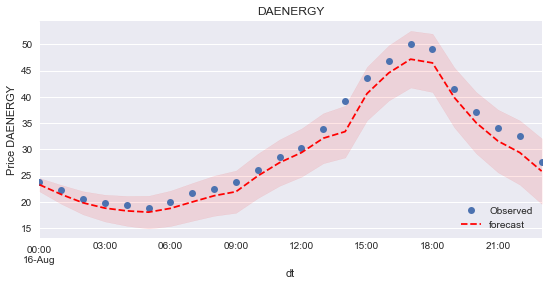

In [14]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 24
ax.set(title='DAENERGY', xlabel='Date', ylabel='Price DAENERGY')

# Plot data points
df.loc['2017-08-16', 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2017-08-16'].plot(ax=ax, style='r--', label='forecast')
ci = predict_ci.loc['2017-08-16']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

### AdaBoost Regressor

In [15]:
from sklearn.ensemble import AdaBoostRegressor

#### Cleaning Data for SKLEARN AdaBoost Model

The model will be trained with the historical data until one day before of the prediction required:

In [16]:
sk_df = df[:'2017-08-15'].copy()
sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
sk.hourofday = sk.hourofday.dt.seconds/3600
sk['daybefore'] = sk.DAENERGY.shift(24)
sk = sk.dropna()
y = sk.pop('DAENERGY').values
X = sk.values

#### Creating Model and Training

In [17]:
model = AdaBoostRegressor()
model = model.fit(X,y)

#### Preparing data of 2017-08-16 to make prediction

In [18]:
input_p = df['2017-08-15':'2017-08-16'].copy()
input_p['daybefore'] = input_p.DAENERGY.shift(24)
input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
input_p.hourofday = input_p.hourofday.dt.seconds/3600
input_p = input_p.dropna()

#### Predictions for 2017-08-16

In [19]:
results = df['2017-08-16'].copy()
pred_ada = model.predict(input_p.values)
results['forecast'] = pred_ada

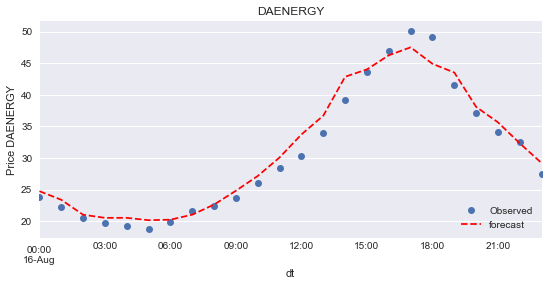

In [20]:
fig, ax = plt.subplots(figsize=(9,4))
npre = 24
ax.set(title='DAENERGY', xlabel='Date', ylabel='Price DAENERGY')

# Plot data points
results.loc['2017-08-16', 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
results.forecast.plot(ax=ax, style='r--', label='forecast')
ci = predict_ci.loc['2017-08-16']
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

In [21]:
RMSE = get_rmse(df['2017-08-16']['DAENERGY'], pred_ada)
print('RMSE for AdaBoost Model: ', RMSE)

RMSE for AdaBoost Model:  1.82091415586


#### Top Features Importance:

In [22]:
input_p.columns.values[np.argsort(model.feature_importances_)[::-1]]


array(['LOAD', 'daybefore', 'KDSM', 'KLRD', 'KCMI', 'KINK', 'KMLI', 'KGRB',
       'KSUX', 'hourofday', 'KELP', 'OUTAGE', 'KTEB', 'KCOU', 'KFWA',
       'KARR', 'KMSN', 'KPIA', 'KSPI', 'KCGX', 'KSTL', 'KAMA', 'ISOWIND',
       'KJCT', 'KDTW', 'KSAT', 'KSGF', 'CYWG', 'KIND', 'HOUROFWEEK',
       'KPHL', 'KLBB', 'KTTN', 'KMAF', 'KODO', 'KDAY', 'KDET', 'KBAZ',
       'KAWM', 'KCAK', 'KATT', 'KAOO', 'KAKR', 'KCRP', 'KAUS', 'KEVV',
       'KSBN', 'KUES', 'KUNV', 'KCRW', 'KCVG', 'KDAL', 'KCMH', 'KRDG',
       'KDBQ', 'KCLE', 'KDCA', 'KDEC', 'KDFW', 'KDLH', 'KDMH', 'KDOV',
       'KTYR', 'KDTO', 'KCLL', 'KCGI', 'KCKB', 'KCID', 'KZZV', 'K2G4',
       'KABE', 'KABI', 'KACT', 'KACY', 'KADS', 'KYNG', 'KANJ', 'KARB',
       'KWRI', 'KAVP', 'KBIS', 'KBPT', 'KBRO', 'KBTR', 'KBWI', 'KTOL',
       'KVCT', 'KELD', 'KEWR', 'KERI', 'KESF', 'KLIT', 'KLNS', 'KROA',
       'KLUK', 'KLYH', 'KMCI', 'KMDT', 'KMDW', 'KMGW', 'KMKE', 'KMKG',
       'KRIC', 'KMLU', 'KMRB', 'KRFD', 'KMSP', 'KMSY', 'KMWL', 'KORD',
 

In [23]:
def train_and_predict(df,date_predict):
    #Prepartinf data to Train
    #print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    sk_df = df[:date_limit].copy()
    sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
    sk.hourofday = sk.hourofday.dt.seconds/3600
    sk['daybefore'] = sk.DAENERGY.shift(24)
    sk = sk.dropna()
    y = sk.pop('DAENERGY').values
    X = sk.values
    
    #Training Model
    #print('Training Model')
    model = AdaBoostRegressor()
    model = model.fit(X,y)
    
    #preparing data to Predict
    #print('Preparing data to predict')
    input_p = df[date_limit:date_predict].copy()
    input_p['daybefore'] = input_p.DAENERGY.shift(24)
    input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
    input_p.hourofday = input_p.hourofday.dt.seconds/3600
    input_p = input_p.dropna()
    
    results = df[date_predict].copy()
    pred_ada = model.predict(input_p.values)
    results['forecast'] = pred_ada
    RMSE = get_rmse(df[date_predict]['DAENERGY'], pred_ada)
    print('RMSE for AdaBoost Model: ', RMSE)
    #preparing to plot
    #print('Ploting results')
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')

    # Plot data points
    df.loc[date_predict, 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    #ci = predict_ci.loc[date_predict]
    #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')
    
    

    return results, RMSE

def create_date_range(start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    dates = []
    cur_dt = start_dt
    dates.append(start_date)
    while cur_dt<end_dt:
        cur_dt = cur_dt + datetime.timedelta(days=1)
        dates.append(cur_dt.strftime('%Y-%m-%d'))
    return dates

RMSE for AdaBoost Model:  3.44901272534


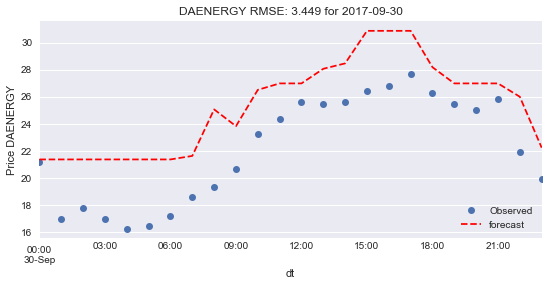

In [26]:
res, rmse = train_and_predict(df,'2017-09-30')

Working for date 2017-08-01
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  3.30973095645
Ploting results
Working for date 2017-08-02
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  1.85269254558
Ploting results
Working for date 2017-08-03
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  1.71157656757
Ploting results
Working for date 2017-08-04
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  1.29461513749
Ploting results
Working for date 2017-08-05
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  2.02066520465
Ploting results
Working for date 2017-08-06
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  1.4592813286
Ploting results
Working for date 2017-08-07
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBo

/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  2.4096638012
Ploting results
Working for date 2017-08-23
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  1.1565671948
Ploting results
Working for date 2017-08-24
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  1.69299451425
Ploting results
Working for date 2017-08-25
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  1.52231566183
Ploting results
Working for date 2017-08-26
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  3.5562827391
Ploting results
Working for date 2017-08-27
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  1.93759628738
Ploting results
Working for date 2017-08-28
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  2.27140514975
Ploting results
Working for date 2017-08-29
Preparing data to Train
Training Model

/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Preparing data to predict
RMSE for AdaBoost Model:  1.60557364769
Ploting results


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Working for date 2017-08-30
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  1.93744449274
Ploting results


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Working for date 2017-08-31
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  1.07892566748
Ploting results


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


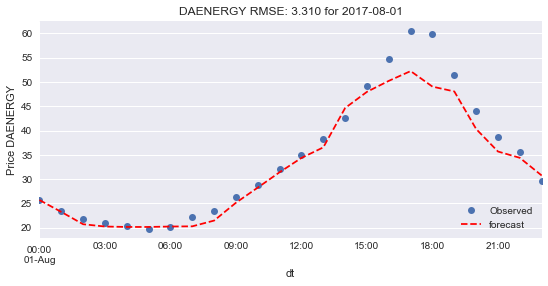

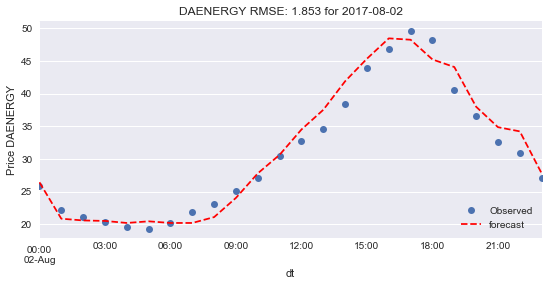

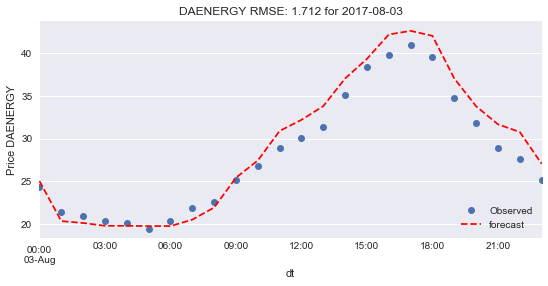

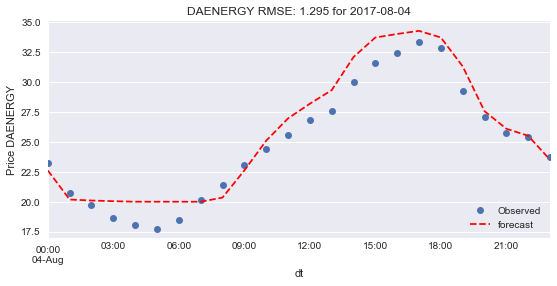

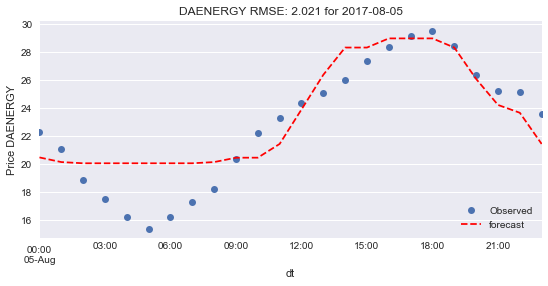

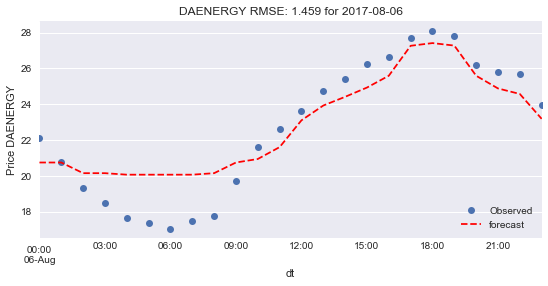

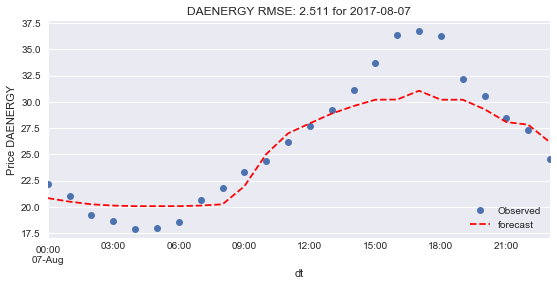

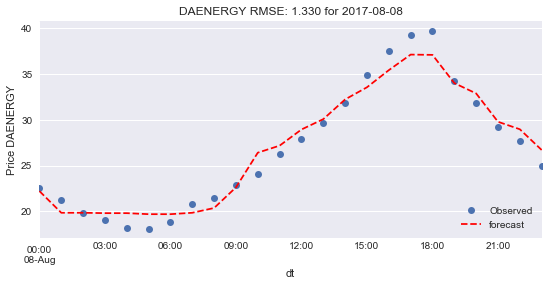

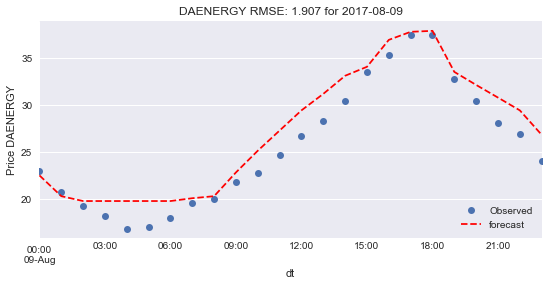

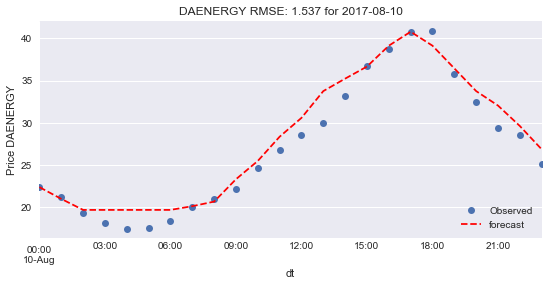

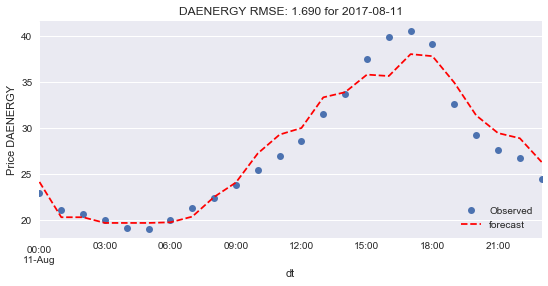

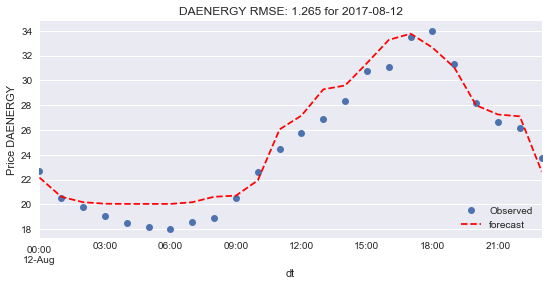

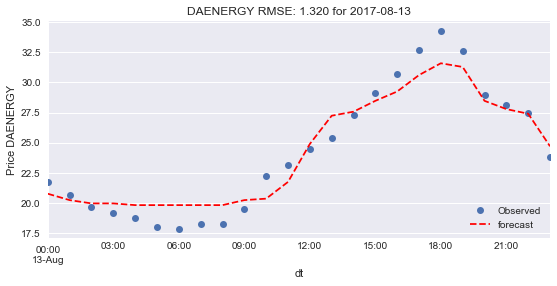

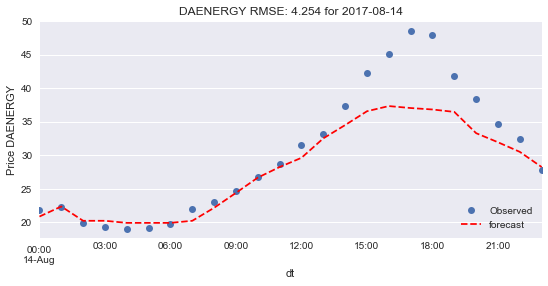

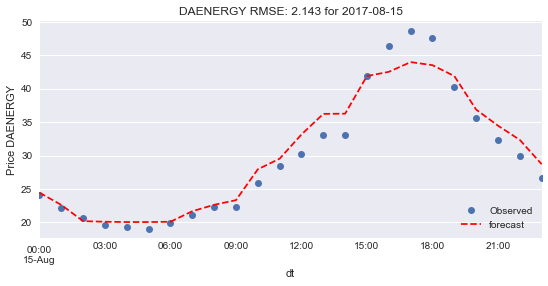

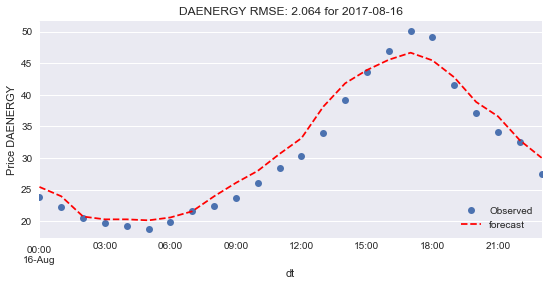

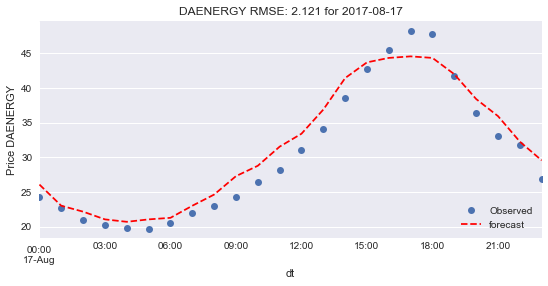

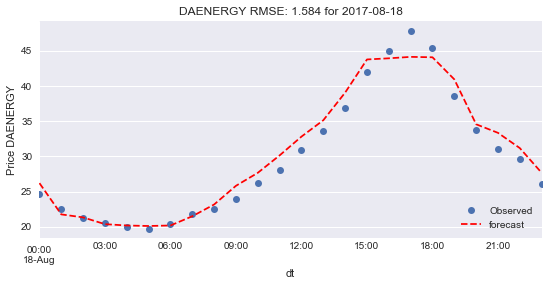

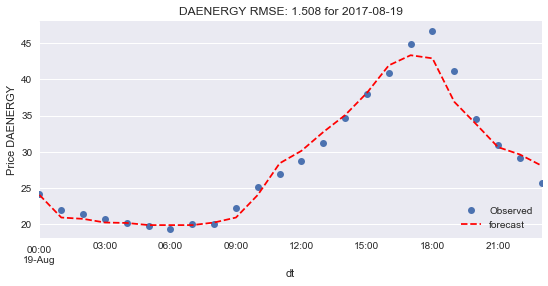

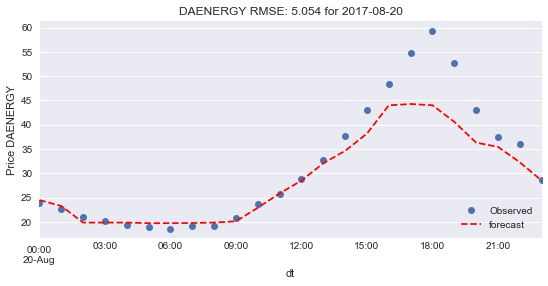

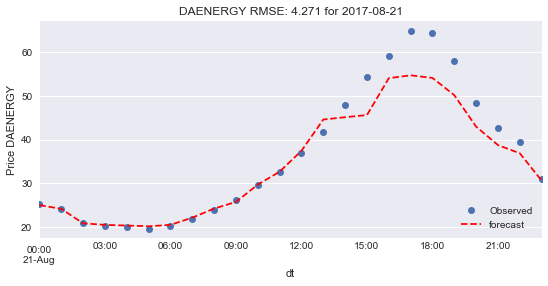

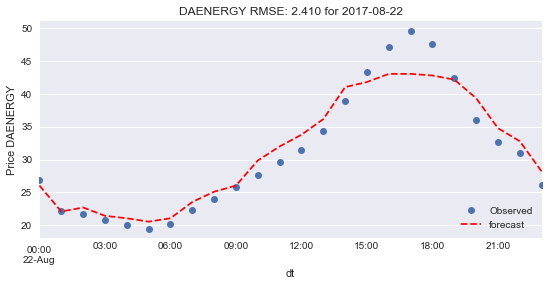

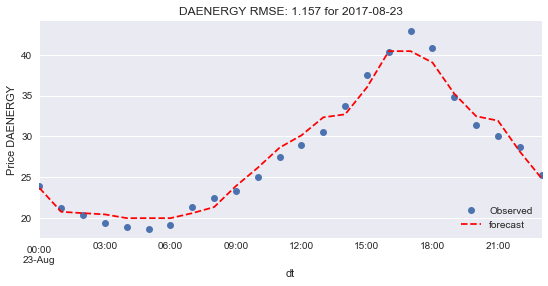

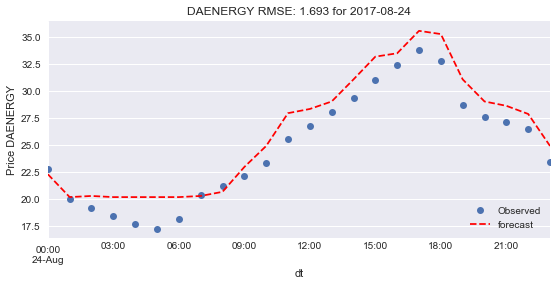

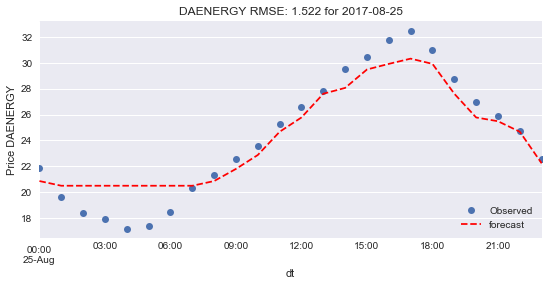

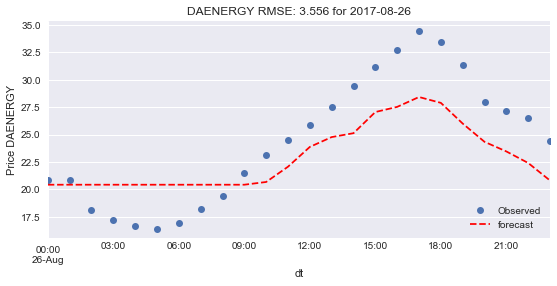

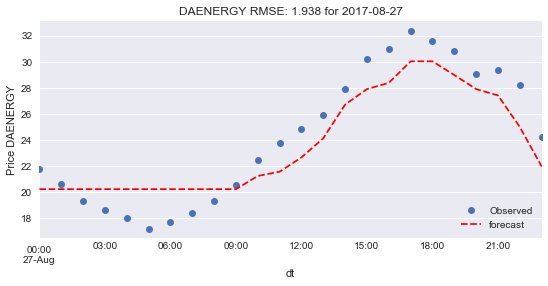

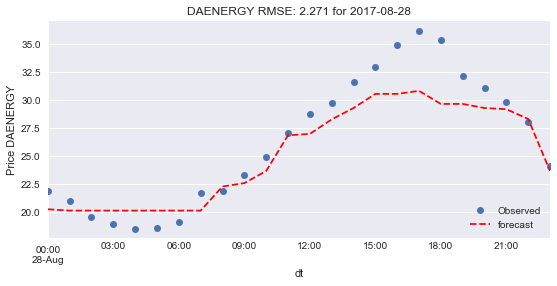

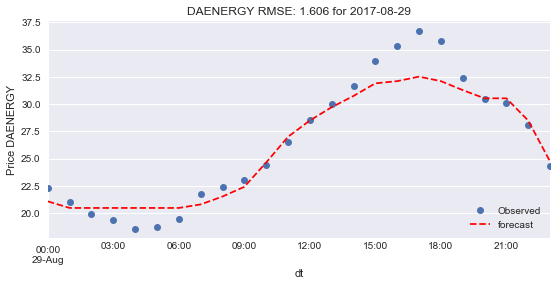

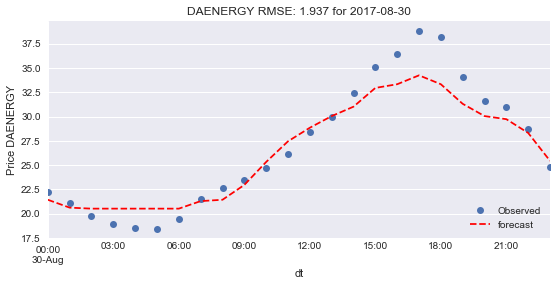

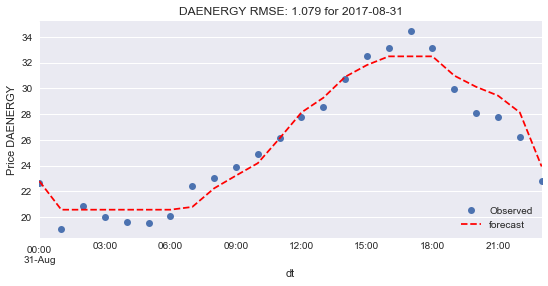

In [83]:
rmses = []
for dt in create_date_range('2017-08-01', '2017-08-31'):
    print('Working for date {}'.format(dt))
    res, rmse = train_and_predict(df,dt)
    rmses.append(rmse)

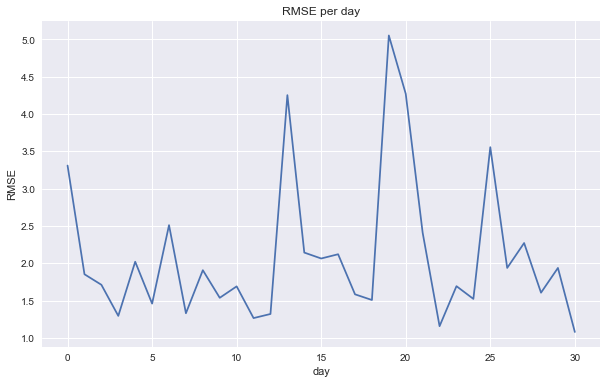

In [87]:
plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day August')
plt.xlabel('day')
plt.ylabel('RMSE')

Working for date 2017-09-01
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  2.71832610083
Ploting results
Working for date 2017-09-02
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  2.39674531685
Ploting results
Working for date 2017-09-03
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  2.14062056309
Ploting results
Working for date 2017-09-04
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  3.32159582979
Ploting results
Working for date 2017-09-05
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  1.55524197152
Ploting results
Working for date 2017-09-06
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  1.89027170744
Ploting results
Working for date 2017-09-07
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaB

/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  10.1524816945
Ploting results


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Working for date 2017-09-23
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  9.73596195509
Ploting results
Working for date 2017-09-24
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  7.78157024211
Ploting results
Working for date 2017-09-25
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  14.4944239891
Ploting results
Working for date 2017-09-26
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  9.94536607409
Ploting results
Working for date 2017-09-27
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  12.2320792844
Ploting results
Working for date 2017-09-28
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  2.50040529372
Ploting results


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Working for date 2017-09-29
Preparing data to Train
Training Model
Preparing data to predict
RMSE for AdaBoost Model:  2.77941848204
Ploting results
Working for date 2017-09-30
Preparing data to Train
Training Model


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Preparing data to predict
RMSE for AdaBoost Model:  4.23598181138
Ploting results


/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


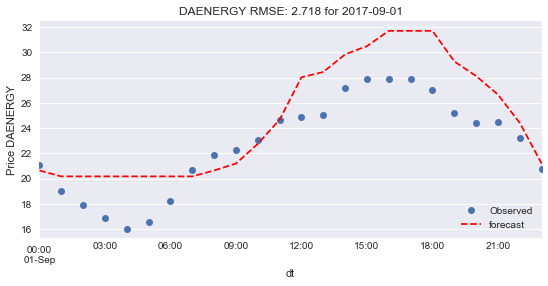

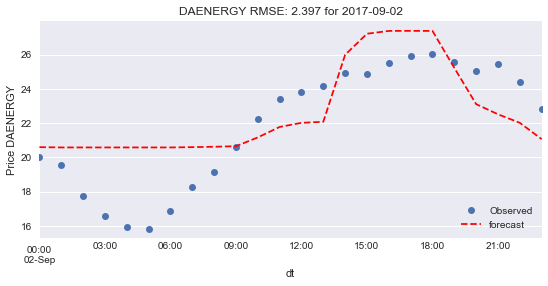

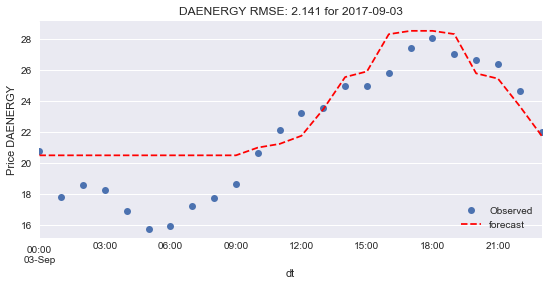

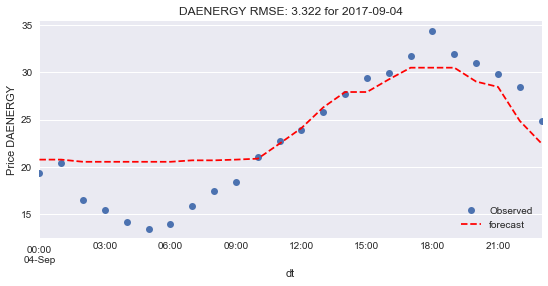

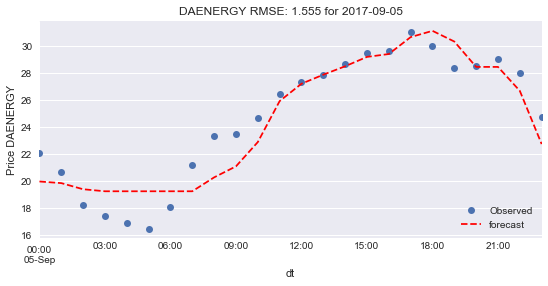

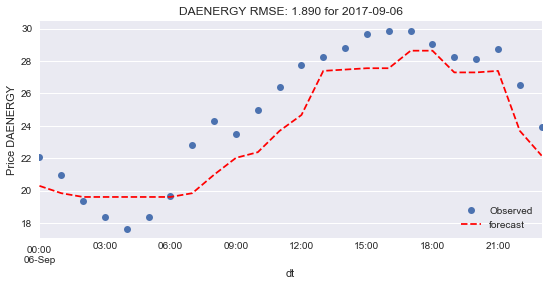

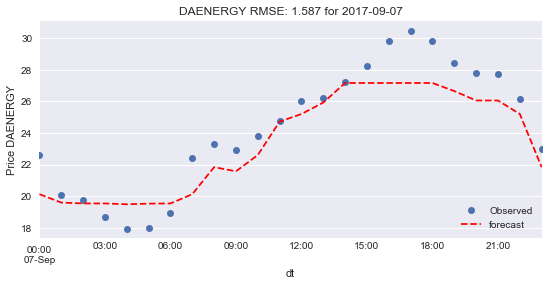

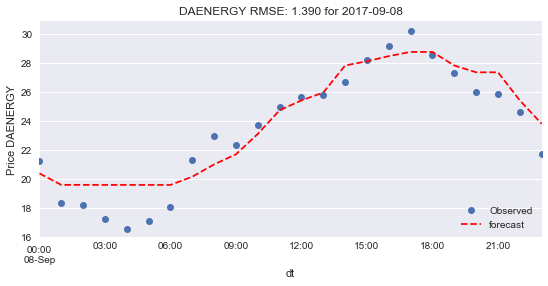

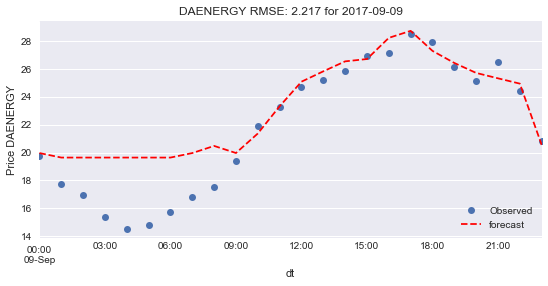

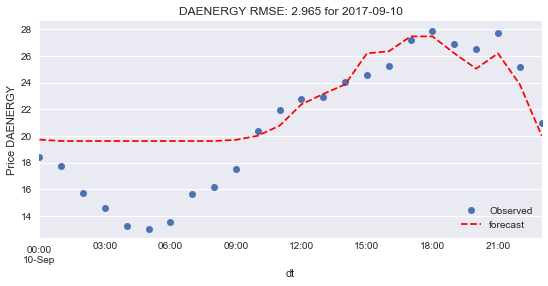

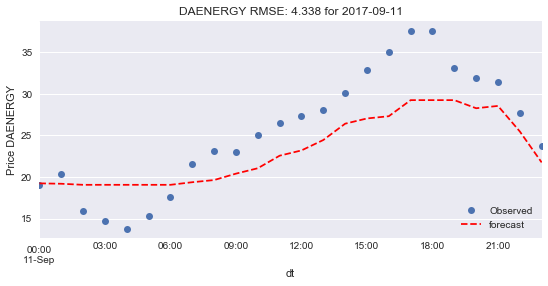

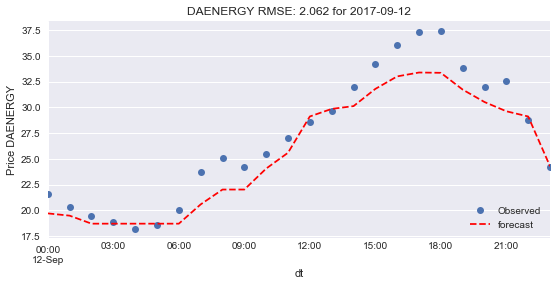

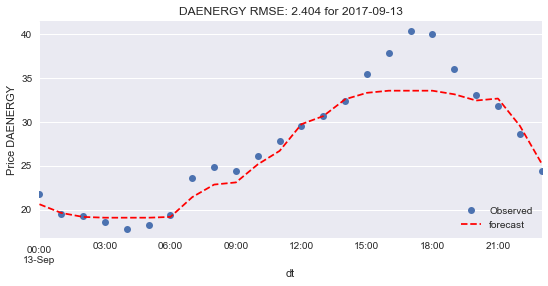

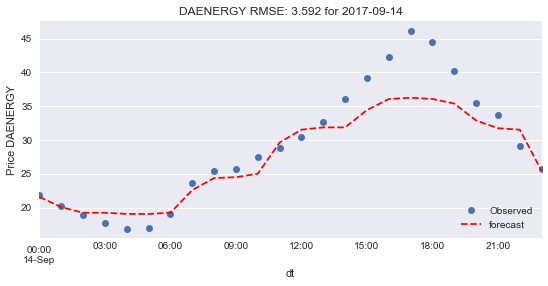

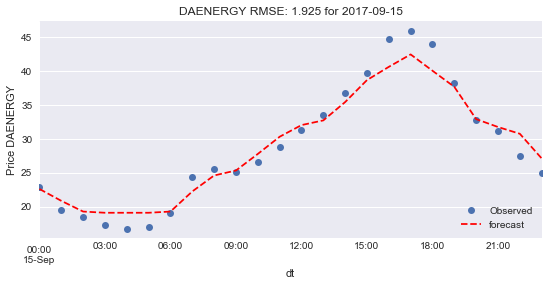

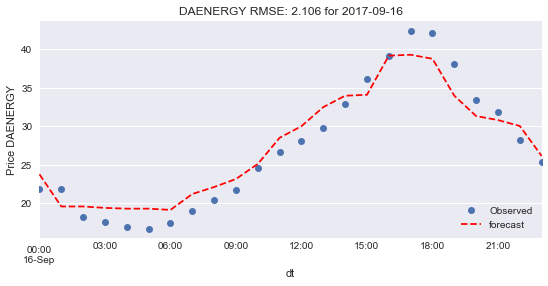

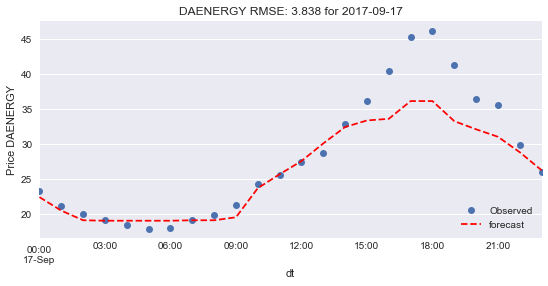

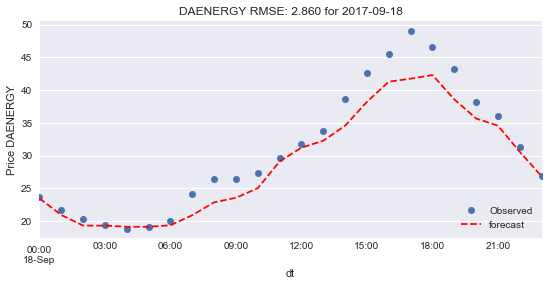

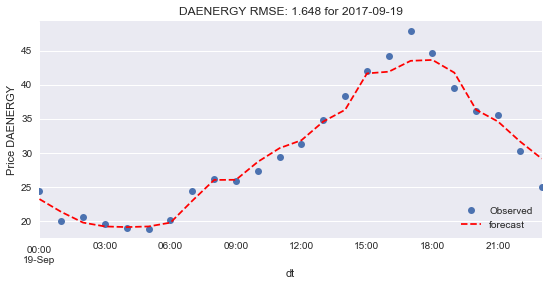

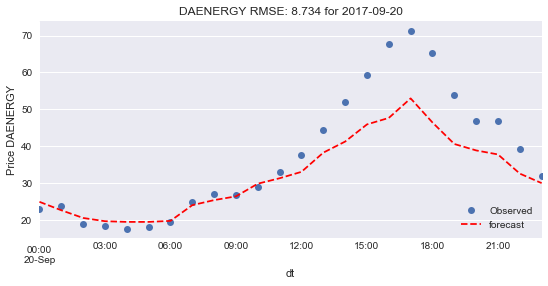

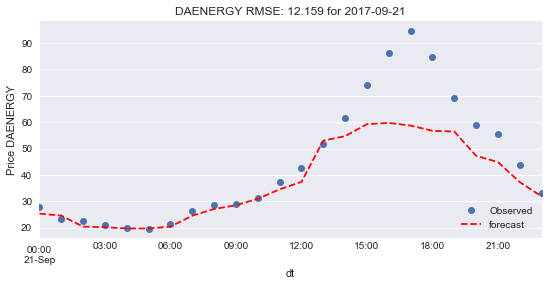

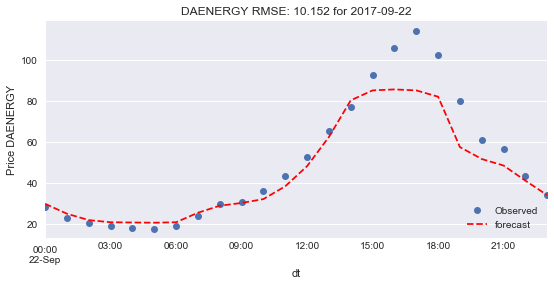

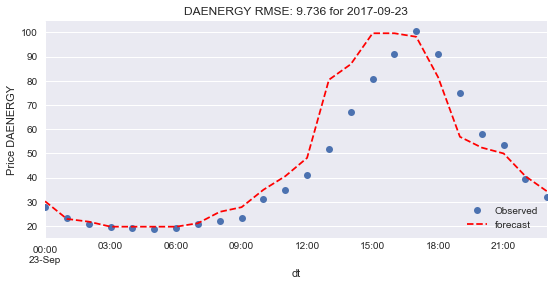

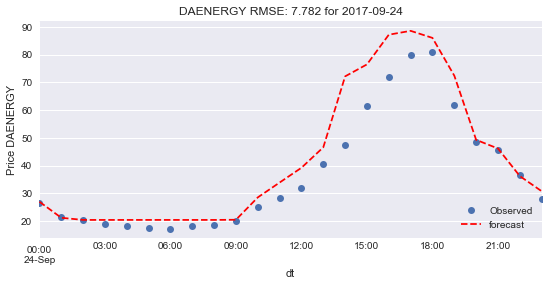

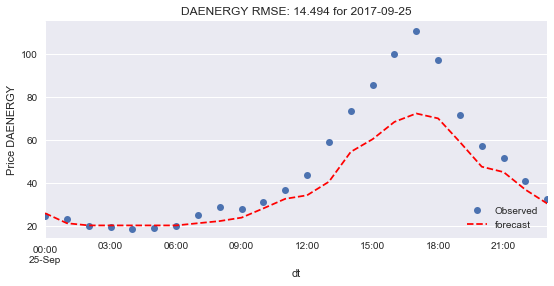

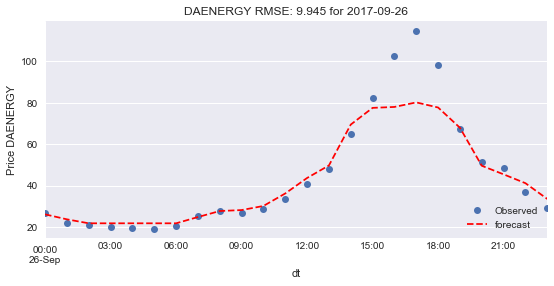

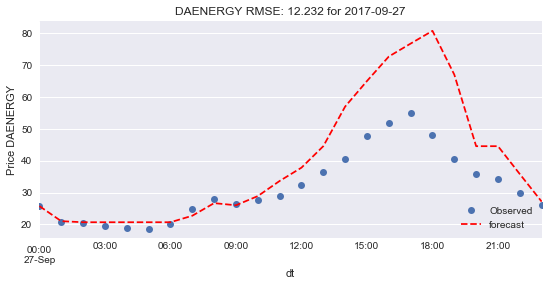

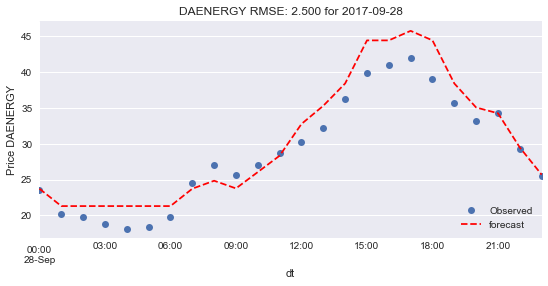

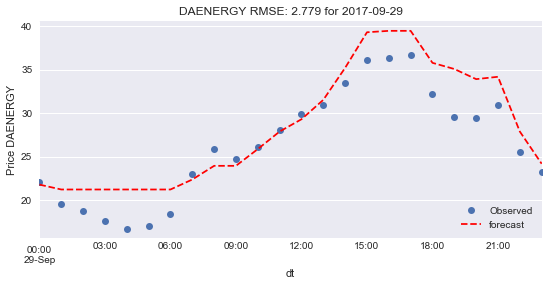

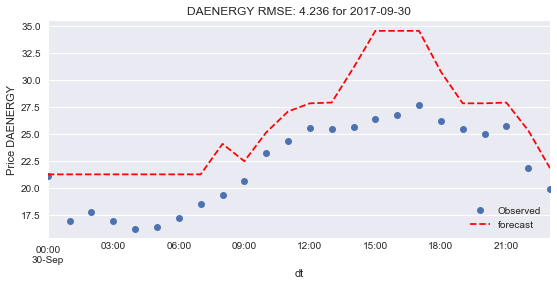

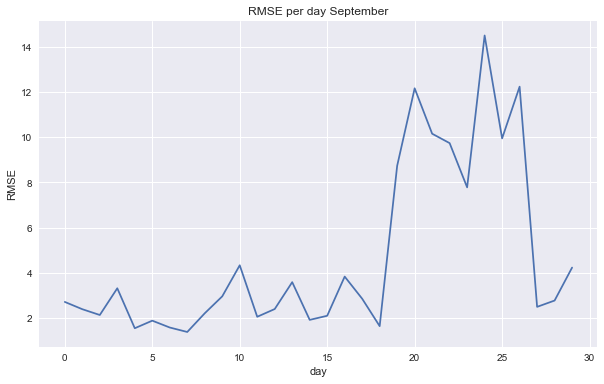

In [88]:
rmses = []
for dt in create_date_range('2017-09-01', '2017-09-30'):
    print('Working for date {}'.format(dt))
    res, rmse = train_and_predict(df,dt)
    rmses.append(rmse)

plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day September')
plt.xlabel('day')
plt.ylabel('RMSE')

In [28]:
df['2017-09-30':'2017-10-01']

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-09-30 00:00:00,2017-09-29,144,47,48,55,62,68,58,69,52,...,75,56,50,51,65683,21.15,21.13,4990.698,34820,00:00:00
2017-09-30 01:00:00,2017-09-30,145,58,38,47,64,66,54,68,43,...,72,51,41,44,59651,16.94,14.16,10139.111,38930,01:00:00
2017-09-30 02:00:00,2017-09-30,146,45,45,53,61,67,58,68,51,...,73,56,48,49,59139,17.76,14.42,5296.367,34820,02:00:00
2017-09-30 03:00:00,2017-09-30,147,44,44,52,60,66,58,67,50,...,73,56,48,48,57481,16.98,16.42,5348.166,34820,03:00:00
2017-09-30 04:00:00,2017-09-30,148,44,43,51,60,65,58,66,49,...,72,55,47,47,56600,16.27,13.82,5391.917,34820,04:00:00
2017-09-30 05:00:00,2017-09-30,149,43,41,51,62,65,56,65,48,...,71,54,45,45,56047,16.43,14.51,5415.679,34820,05:00:00
2017-09-30 06:00:00,2017-09-30,150,43,40,50,61,64,55,65,48,...,70,53,45,45,56713,17.20,14.63,5540.652,34820,06:00:00
2017-09-30 07:00:00,2017-09-30,151,43,40,51,61,64,55,65,48,...,70,54,45,46,58551,18.58,16.37,5757.243,34820,07:00:00
2017-09-30 08:00:00,2017-09-30,152,46,41,55,62,66,58,66,50,...,70,57,47,49,60315,19.36,18.56,6005.349,34820,08:00:00
